In [1]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import numpy as np


In [2]:
#画像の変形処理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#CIFAR-10のtrain, testsetのロード
#変形はtransformを適用
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#DataLoaderの適用->これによりバッチの割り当て・シャッフルをまとめて行うことができる
#batch_sizeでバッチサイズを指定
#num_workersでいくつのコアでデータをロードするか指定(デフォルトはメインのみ)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # [3, 32, 32] => [6, 28, 28]
        self.conv2 = nn.Conv2d(6, 16, 5) # [6, 28, 28] => [16, 24, 24]
        self.pool = nn.MaxPool2d(2, 2) # [N,C,H,W] => [N, C, H/2, W/2]
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [4]:
#モデル定義
model = CNN()

#Loss関数の指定
criterion = nn.CrossEntropyLoss()

#Optimizerの指定
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [59]:
cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if cuda:
    model.cuda()
    criterion.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [61]:
#トレーニング
#エポック数の指定
for epoch in range(1):  # loop over the dataset multiple times

    #データ全てのトータルロス
    running_loss = 0.0 


    for i, (inputs, labels) in enumerate(trainloader):

        # Variableに変形
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        if cuda:
            inputs.cuda()
            labels.cuda()
        
        # optimizerの初期化
        # zero the parameter gradients
        optimizer.zero_grad()

        #一連の流れ
        # forward + backward + optimize
        outputs = model(inputs)

        #ここでラベルデータに対するCross-Entropyがとられる
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # ロスの表示
            # print statistics
            print("epoch %d, batch%d/%d, acc %f, loss%f" 
              % (epoch, i, len(trainloader), 
                 torch.eq(torch.max(outputs, 1).indices, labels).double().mean(), 
                 loss.item()))

with torch.no_grad():
    acc = [torch.eq(torch.max(model(inputs), 1).indices, labels).double().mean().item()
             for _, (inputs, labels) in enumerate(testloader)]
    print(acc)
    accuracy = torch.Tensor(acc).mean()
    print(accuracy)
        
print('Finished Training')

epoch 0, batch0/3125, acc 0.562500, loss1.460260
epoch 0, batch1/3125, acc 0.437500, loss1.604814
epoch 0, batch2/3125, acc 0.562500, loss1.374325
epoch 0, batch3/3125, acc 0.250000, loss1.441139
epoch 0, batch4/3125, acc 0.812500, loss1.007231
epoch 0, batch5/3125, acc 0.500000, loss1.163764
epoch 0, batch6/3125, acc 0.500000, loss1.266983
epoch 0, batch7/3125, acc 0.750000, loss0.927870
epoch 0, batch8/3125, acc 0.562500, loss1.341212
epoch 0, batch9/3125, acc 0.375000, loss1.238957
epoch 0, batch10/3125, acc 0.562500, loss1.282729
epoch 0, batch11/3125, acc 0.750000, loss1.035063
epoch 0, batch12/3125, acc 0.437500, loss1.434173
epoch 0, batch13/3125, acc 0.375000, loss1.379825
epoch 0, batch14/3125, acc 0.687500, loss1.122577
epoch 0, batch15/3125, acc 0.375000, loss1.797715
epoch 0, batch16/3125, acc 0.625000, loss1.098946
epoch 0, batch17/3125, acc 0.500000, loss1.264185
epoch 0, batch18/3125, acc 0.625000, loss1.004073
epoch 0, batch19/3125, acc 0.562500, loss1.193961
epoch 0, b

epoch 0, batch162/3125, acc 0.500000, loss1.279563
epoch 0, batch163/3125, acc 0.750000, loss0.783198
epoch 0, batch164/3125, acc 0.500000, loss1.248765
epoch 0, batch165/3125, acc 0.500000, loss1.505238
epoch 0, batch166/3125, acc 0.562500, loss1.235096
epoch 0, batch167/3125, acc 0.437500, loss1.465817
epoch 0, batch168/3125, acc 0.500000, loss1.591879
epoch 0, batch169/3125, acc 0.437500, loss1.353631
epoch 0, batch170/3125, acc 0.500000, loss1.048300
epoch 0, batch171/3125, acc 0.750000, loss0.857433
epoch 0, batch172/3125, acc 0.437500, loss1.339502
epoch 0, batch173/3125, acc 0.687500, loss1.016700
epoch 0, batch174/3125, acc 0.375000, loss1.612345
epoch 0, batch175/3125, acc 0.500000, loss1.136269
epoch 0, batch176/3125, acc 0.562500, loss0.971260
epoch 0, batch177/3125, acc 0.500000, loss1.359968
epoch 0, batch178/3125, acc 0.375000, loss1.529284
epoch 0, batch179/3125, acc 0.312500, loss1.477297
epoch 0, batch180/3125, acc 0.625000, loss1.253820
epoch 0, batch181/3125, acc 0.6

epoch 0, batch322/3125, acc 0.687500, loss1.027610
epoch 0, batch323/3125, acc 0.437500, loss1.404928
epoch 0, batch324/3125, acc 0.625000, loss1.074419
epoch 0, batch325/3125, acc 0.250000, loss1.916103
epoch 0, batch326/3125, acc 0.500000, loss1.265913
epoch 0, batch327/3125, acc 0.375000, loss1.589951
epoch 0, batch328/3125, acc 0.375000, loss1.567966
epoch 0, batch329/3125, acc 0.312500, loss1.901908
epoch 0, batch330/3125, acc 0.375000, loss1.594975
epoch 0, batch331/3125, acc 0.750000, loss0.833883
epoch 0, batch332/3125, acc 0.500000, loss1.195708
epoch 0, batch333/3125, acc 0.687500, loss0.849688
epoch 0, batch334/3125, acc 0.437500, loss1.595944
epoch 0, batch335/3125, acc 0.437500, loss1.568089
epoch 0, batch336/3125, acc 0.625000, loss0.914612
epoch 0, batch337/3125, acc 0.437500, loss1.388724
epoch 0, batch338/3125, acc 0.687500, loss1.144342
epoch 0, batch339/3125, acc 0.375000, loss1.515089
epoch 0, batch340/3125, acc 0.375000, loss1.412078
epoch 0, batch341/3125, acc 0.6

epoch 0, batch482/3125, acc 0.625000, loss0.988214
epoch 0, batch483/3125, acc 0.375000, loss1.583749
epoch 0, batch484/3125, acc 0.625000, loss1.312017
epoch 0, batch485/3125, acc 0.500000, loss1.422466
epoch 0, batch486/3125, acc 0.687500, loss0.778585
epoch 0, batch487/3125, acc 0.687500, loss1.170944
epoch 0, batch488/3125, acc 0.437500, loss1.643225
epoch 0, batch489/3125, acc 0.125000, loss1.972075
epoch 0, batch490/3125, acc 0.437500, loss1.576024
epoch 0, batch491/3125, acc 0.500000, loss1.456155
epoch 0, batch492/3125, acc 0.312500, loss1.543459
epoch 0, batch493/3125, acc 0.562500, loss1.145902
epoch 0, batch494/3125, acc 0.312500, loss1.601717
epoch 0, batch495/3125, acc 0.625000, loss1.009114
epoch 0, batch496/3125, acc 0.500000, loss1.143357
epoch 0, batch497/3125, acc 0.500000, loss1.445147
epoch 0, batch498/3125, acc 0.375000, loss1.387016
epoch 0, batch499/3125, acc 0.375000, loss1.910211
epoch 0, batch500/3125, acc 0.625000, loss1.054595
epoch 0, batch501/3125, acc 0.6

epoch 0, batch642/3125, acc 0.500000, loss1.332919
epoch 0, batch643/3125, acc 0.437500, loss1.490319
epoch 0, batch644/3125, acc 0.562500, loss1.118634
epoch 0, batch645/3125, acc 0.437500, loss1.256751
epoch 0, batch646/3125, acc 0.500000, loss1.372067
epoch 0, batch647/3125, acc 0.687500, loss0.954037
epoch 0, batch648/3125, acc 0.687500, loss1.110123
epoch 0, batch649/3125, acc 0.562500, loss1.598021
epoch 0, batch650/3125, acc 0.437500, loss1.188395
epoch 0, batch651/3125, acc 0.312500, loss1.613270
epoch 0, batch652/3125, acc 0.750000, loss0.895845
epoch 0, batch653/3125, acc 0.625000, loss1.056100
epoch 0, batch654/3125, acc 0.437500, loss1.485414
epoch 0, batch655/3125, acc 0.500000, loss1.410908
epoch 0, batch656/3125, acc 0.750000, loss1.127238
epoch 0, batch657/3125, acc 0.500000, loss1.223240
epoch 0, batch658/3125, acc 0.687500, loss1.022539
epoch 0, batch659/3125, acc 0.500000, loss1.263144
epoch 0, batch660/3125, acc 0.687500, loss1.026199
epoch 0, batch661/3125, acc 0.4

epoch 0, batch802/3125, acc 0.375000, loss1.440902
epoch 0, batch803/3125, acc 0.562500, loss1.337949
epoch 0, batch804/3125, acc 0.500000, loss1.466098
epoch 0, batch805/3125, acc 0.625000, loss1.115637
epoch 0, batch806/3125, acc 0.750000, loss0.933284
epoch 0, batch807/3125, acc 0.562500, loss1.420173
epoch 0, batch808/3125, acc 0.375000, loss1.392434
epoch 0, batch809/3125, acc 0.625000, loss1.053772
epoch 0, batch810/3125, acc 0.687500, loss1.082477
epoch 0, batch811/3125, acc 0.687500, loss0.934799
epoch 0, batch812/3125, acc 0.500000, loss1.163565
epoch 0, batch813/3125, acc 0.687500, loss1.042511
epoch 0, batch814/3125, acc 0.625000, loss1.057301
epoch 0, batch815/3125, acc 0.562500, loss1.409838
epoch 0, batch816/3125, acc 0.500000, loss1.616627
epoch 0, batch817/3125, acc 0.687500, loss1.103574
epoch 0, batch818/3125, acc 0.687500, loss1.099650
epoch 0, batch819/3125, acc 0.437500, loss1.590185
epoch 0, batch820/3125, acc 0.500000, loss1.399705
epoch 0, batch821/3125, acc 0.5

epoch 0, batch962/3125, acc 0.625000, loss1.456401
epoch 0, batch963/3125, acc 0.375000, loss1.452871
epoch 0, batch964/3125, acc 0.375000, loss1.487210
epoch 0, batch965/3125, acc 0.625000, loss1.538995
epoch 0, batch966/3125, acc 0.562500, loss1.362028
epoch 0, batch967/3125, acc 0.562500, loss1.577448
epoch 0, batch968/3125, acc 0.562500, loss1.175682
epoch 0, batch969/3125, acc 0.750000, loss1.081833
epoch 0, batch970/3125, acc 0.625000, loss0.920290
epoch 0, batch971/3125, acc 0.562500, loss1.318479
epoch 0, batch972/3125, acc 0.625000, loss1.061492
epoch 0, batch973/3125, acc 0.625000, loss1.301729
epoch 0, batch974/3125, acc 0.500000, loss1.309848
epoch 0, batch975/3125, acc 0.437500, loss1.255937
epoch 0, batch976/3125, acc 0.500000, loss1.566475
epoch 0, batch977/3125, acc 0.375000, loss1.511501
epoch 0, batch978/3125, acc 0.750000, loss1.105300
epoch 0, batch979/3125, acc 0.500000, loss1.478379
epoch 0, batch980/3125, acc 0.437500, loss1.232705
epoch 0, batch981/3125, acc 0.8

epoch 0, batch1120/3125, acc 0.562500, loss1.099952
epoch 0, batch1121/3125, acc 0.562500, loss1.354713
epoch 0, batch1122/3125, acc 0.437500, loss1.416292
epoch 0, batch1123/3125, acc 0.375000, loss1.494014
epoch 0, batch1124/3125, acc 0.375000, loss1.631940
epoch 0, batch1125/3125, acc 0.562500, loss1.149416
epoch 0, batch1126/3125, acc 0.562500, loss1.162149
epoch 0, batch1127/3125, acc 0.500000, loss1.237196
epoch 0, batch1128/3125, acc 0.437500, loss1.699383
epoch 0, batch1129/3125, acc 0.437500, loss1.297897
epoch 0, batch1130/3125, acc 0.625000, loss1.183763
epoch 0, batch1131/3125, acc 0.562500, loss1.481761
epoch 0, batch1132/3125, acc 0.625000, loss1.226301
epoch 0, batch1133/3125, acc 0.437500, loss1.628218
epoch 0, batch1134/3125, acc 0.375000, loss1.656540
epoch 0, batch1135/3125, acc 0.437500, loss1.501343
epoch 0, batch1136/3125, acc 0.437500, loss1.415593
epoch 0, batch1137/3125, acc 0.562500, loss1.402535
epoch 0, batch1138/3125, acc 0.625000, loss1.274995
epoch 0, bat

epoch 0, batch1277/3125, acc 0.750000, loss0.868362
epoch 0, batch1278/3125, acc 0.500000, loss1.436666
epoch 0, batch1279/3125, acc 0.562500, loss1.055185
epoch 0, batch1280/3125, acc 0.437500, loss1.332009
epoch 0, batch1281/3125, acc 0.625000, loss1.243997
epoch 0, batch1282/3125, acc 0.500000, loss1.291824
epoch 0, batch1283/3125, acc 0.562500, loss1.087392
epoch 0, batch1284/3125, acc 0.500000, loss1.397386
epoch 0, batch1285/3125, acc 0.500000, loss1.282823
epoch 0, batch1286/3125, acc 0.625000, loss1.070125
epoch 0, batch1287/3125, acc 0.562500, loss1.820272
epoch 0, batch1288/3125, acc 0.562500, loss1.000894
epoch 0, batch1289/3125, acc 0.687500, loss1.210749
epoch 0, batch1290/3125, acc 0.375000, loss1.359850
epoch 0, batch1291/3125, acc 0.562500, loss1.476845
epoch 0, batch1292/3125, acc 0.312500, loss1.925130
epoch 0, batch1293/3125, acc 0.562500, loss1.571600
epoch 0, batch1294/3125, acc 0.562500, loss1.529146
epoch 0, batch1295/3125, acc 0.375000, loss1.524530
epoch 0, bat

epoch 0, batch1434/3125, acc 0.562500, loss1.391079
epoch 0, batch1435/3125, acc 0.562500, loss1.687838
epoch 0, batch1436/3125, acc 0.500000, loss1.345098
epoch 0, batch1437/3125, acc 0.625000, loss1.236172
epoch 0, batch1438/3125, acc 0.375000, loss1.548208
epoch 0, batch1439/3125, acc 0.562500, loss1.279597
epoch 0, batch1440/3125, acc 0.500000, loss1.597240
epoch 0, batch1441/3125, acc 0.500000, loss1.311447
epoch 0, batch1442/3125, acc 0.750000, loss0.876863
epoch 0, batch1443/3125, acc 0.437500, loss1.375319
epoch 0, batch1444/3125, acc 0.375000, loss1.494213
epoch 0, batch1445/3125, acc 0.625000, loss1.034408
epoch 0, batch1446/3125, acc 0.687500, loss0.790968
epoch 0, batch1447/3125, acc 0.500000, loss1.349470
epoch 0, batch1448/3125, acc 0.625000, loss1.278605
epoch 0, batch1449/3125, acc 0.625000, loss1.660539
epoch 0, batch1450/3125, acc 0.750000, loss1.063137
epoch 0, batch1451/3125, acc 0.437500, loss1.484838
epoch 0, batch1452/3125, acc 0.562500, loss1.299197
epoch 0, bat

epoch 0, batch1591/3125, acc 0.500000, loss1.169314
epoch 0, batch1592/3125, acc 0.625000, loss1.404716
epoch 0, batch1593/3125, acc 0.500000, loss1.311499
epoch 0, batch1594/3125, acc 0.625000, loss1.321938
epoch 0, batch1595/3125, acc 0.437500, loss1.636339
epoch 0, batch1596/3125, acc 0.750000, loss0.761181
epoch 0, batch1597/3125, acc 0.125000, loss1.578012
epoch 0, batch1598/3125, acc 0.500000, loss1.155297
epoch 0, batch1599/3125, acc 0.500000, loss1.366663
epoch 0, batch1600/3125, acc 0.437500, loss2.077243
epoch 0, batch1601/3125, acc 0.625000, loss1.215909
epoch 0, batch1602/3125, acc 0.562500, loss1.306016
epoch 0, batch1603/3125, acc 0.562500, loss1.296913
epoch 0, batch1604/3125, acc 0.625000, loss1.003743
epoch 0, batch1605/3125, acc 0.375000, loss1.932628
epoch 0, batch1606/3125, acc 0.500000, loss1.289308
epoch 0, batch1607/3125, acc 0.687500, loss1.083516
epoch 0, batch1608/3125, acc 0.750000, loss1.283420
epoch 0, batch1609/3125, acc 0.687500, loss0.835844
epoch 0, bat

epoch 0, batch1748/3125, acc 0.375000, loss1.805707
epoch 0, batch1749/3125, acc 0.375000, loss1.507185
epoch 0, batch1750/3125, acc 0.437500, loss1.538524
epoch 0, batch1751/3125, acc 0.562500, loss1.349499
epoch 0, batch1752/3125, acc 0.500000, loss1.424713
epoch 0, batch1753/3125, acc 0.625000, loss0.924494
epoch 0, batch1754/3125, acc 0.312500, loss2.131899
epoch 0, batch1755/3125, acc 0.437500, loss1.938184
epoch 0, batch1756/3125, acc 0.562500, loss1.205790
epoch 0, batch1757/3125, acc 0.562500, loss1.094275
epoch 0, batch1758/3125, acc 0.500000, loss1.266315
epoch 0, batch1759/3125, acc 0.812500, loss0.726959
epoch 0, batch1760/3125, acc 0.812500, loss0.889924
epoch 0, batch1761/3125, acc 0.625000, loss1.110009
epoch 0, batch1762/3125, acc 0.562500, loss1.037865
epoch 0, batch1763/3125, acc 0.687500, loss1.045311
epoch 0, batch1764/3125, acc 0.437500, loss1.627229
epoch 0, batch1765/3125, acc 0.562500, loss1.646532
epoch 0, batch1766/3125, acc 0.437500, loss1.399471
epoch 0, bat

epoch 0, batch1905/3125, acc 0.812500, loss0.882918
epoch 0, batch1906/3125, acc 0.375000, loss1.786519
epoch 0, batch1907/3125, acc 0.562500, loss1.289039
epoch 0, batch1908/3125, acc 0.625000, loss1.041920
epoch 0, batch1909/3125, acc 0.562500, loss0.964623
epoch 0, batch1910/3125, acc 0.437500, loss1.377389
epoch 0, batch1911/3125, acc 0.437500, loss1.290713
epoch 0, batch1912/3125, acc 0.500000, loss1.269646
epoch 0, batch1913/3125, acc 0.562500, loss1.135913
epoch 0, batch1914/3125, acc 0.562500, loss1.529035
epoch 0, batch1915/3125, acc 0.562500, loss1.198733
epoch 0, batch1916/3125, acc 0.500000, loss1.288241
epoch 0, batch1917/3125, acc 0.562500, loss1.327578
epoch 0, batch1918/3125, acc 0.500000, loss1.222435
epoch 0, batch1919/3125, acc 0.500000, loss1.438755
epoch 0, batch1920/3125, acc 0.625000, loss1.462648
epoch 0, batch1921/3125, acc 0.687500, loss1.153898
epoch 0, batch1922/3125, acc 0.562500, loss1.084359
epoch 0, batch1923/3125, acc 0.250000, loss1.702057
epoch 0, bat

epoch 0, batch2062/3125, acc 0.437500, loss1.428579
epoch 0, batch2063/3125, acc 0.375000, loss1.431723
epoch 0, batch2064/3125, acc 0.562500, loss1.376732
epoch 0, batch2065/3125, acc 0.500000, loss1.173375
epoch 0, batch2066/3125, acc 0.500000, loss1.485538
epoch 0, batch2067/3125, acc 0.562500, loss1.041264
epoch 0, batch2068/3125, acc 0.500000, loss1.166789
epoch 0, batch2069/3125, acc 0.625000, loss1.125238
epoch 0, batch2070/3125, acc 0.437500, loss1.536003
epoch 0, batch2071/3125, acc 0.250000, loss1.599998
epoch 0, batch2072/3125, acc 0.687500, loss1.271954
epoch 0, batch2073/3125, acc 0.562500, loss1.055607
epoch 0, batch2074/3125, acc 0.562500, loss1.137093
epoch 0, batch2075/3125, acc 0.437500, loss1.539806
epoch 0, batch2076/3125, acc 0.500000, loss1.464656
epoch 0, batch2077/3125, acc 0.750000, loss0.899005
epoch 0, batch2078/3125, acc 0.375000, loss2.071918
epoch 0, batch2079/3125, acc 0.500000, loss1.362782
epoch 0, batch2080/3125, acc 0.562500, loss1.303866
epoch 0, bat

epoch 0, batch2219/3125, acc 0.500000, loss1.312055
epoch 0, batch2220/3125, acc 0.562500, loss1.642033
epoch 0, batch2221/3125, acc 0.375000, loss1.511314
epoch 0, batch2222/3125, acc 0.437500, loss1.578881
epoch 0, batch2223/3125, acc 0.500000, loss1.598694
epoch 0, batch2224/3125, acc 0.750000, loss0.925851
epoch 0, batch2225/3125, acc 0.625000, loss1.302271
epoch 0, batch2226/3125, acc 0.812500, loss0.913710
epoch 0, batch2227/3125, acc 0.312500, loss1.982238
epoch 0, batch2228/3125, acc 0.625000, loss1.181466
epoch 0, batch2229/3125, acc 0.437500, loss1.609444
epoch 0, batch2230/3125, acc 0.625000, loss1.176151
epoch 0, batch2231/3125, acc 0.250000, loss1.984947
epoch 0, batch2232/3125, acc 0.500000, loss1.240120
epoch 0, batch2233/3125, acc 0.562500, loss1.452742
epoch 0, batch2234/3125, acc 0.437500, loss1.697990
epoch 0, batch2235/3125, acc 0.375000, loss1.501295
epoch 0, batch2236/3125, acc 0.562500, loss1.079839
epoch 0, batch2237/3125, acc 0.625000, loss1.202287
epoch 0, bat

epoch 0, batch2376/3125, acc 0.500000, loss1.219028
epoch 0, batch2377/3125, acc 0.875000, loss0.736699
epoch 0, batch2378/3125, acc 0.687500, loss0.949987
epoch 0, batch2379/3125, acc 0.437500, loss1.181715
epoch 0, batch2380/3125, acc 0.500000, loss1.096569
epoch 0, batch2381/3125, acc 0.375000, loss1.465877
epoch 0, batch2382/3125, acc 0.500000, loss1.826868
epoch 0, batch2383/3125, acc 0.562500, loss1.490487
epoch 0, batch2384/3125, acc 0.437500, loss2.444328
epoch 0, batch2385/3125, acc 0.750000, loss1.303014
epoch 0, batch2386/3125, acc 0.687500, loss1.164424
epoch 0, batch2387/3125, acc 0.437500, loss1.281965
epoch 0, batch2388/3125, acc 0.562500, loss1.786899
epoch 0, batch2389/3125, acc 0.687500, loss0.993192
epoch 0, batch2390/3125, acc 0.562500, loss1.374004
epoch 0, batch2391/3125, acc 0.437500, loss1.380645
epoch 0, batch2392/3125, acc 0.562500, loss1.247628
epoch 0, batch2393/3125, acc 0.625000, loss1.272647
epoch 0, batch2394/3125, acc 0.562500, loss1.157824
epoch 0, bat

epoch 0, batch2533/3125, acc 0.437500, loss1.303898
epoch 0, batch2534/3125, acc 0.437500, loss1.207425
epoch 0, batch2535/3125, acc 0.500000, loss1.365615
epoch 0, batch2536/3125, acc 0.437500, loss0.938015
epoch 0, batch2537/3125, acc 0.750000, loss0.986908
epoch 0, batch2538/3125, acc 0.437500, loss1.390377
epoch 0, batch2539/3125, acc 0.500000, loss1.579195
epoch 0, batch2540/3125, acc 0.562500, loss1.149476
epoch 0, batch2541/3125, acc 0.500000, loss1.212221
epoch 0, batch2542/3125, acc 0.750000, loss0.975950
epoch 0, batch2543/3125, acc 0.625000, loss1.123989
epoch 0, batch2544/3125, acc 0.625000, loss1.093065
epoch 0, batch2545/3125, acc 0.500000, loss1.136843
epoch 0, batch2546/3125, acc 0.625000, loss1.193070
epoch 0, batch2547/3125, acc 0.625000, loss1.100359
epoch 0, batch2548/3125, acc 0.375000, loss1.383026
epoch 0, batch2549/3125, acc 0.500000, loss1.296363
epoch 0, batch2550/3125, acc 0.562500, loss1.002757
epoch 0, batch2551/3125, acc 0.625000, loss1.195469
epoch 0, bat

epoch 0, batch2690/3125, acc 0.500000, loss1.486060
epoch 0, batch2691/3125, acc 0.562500, loss1.462786
epoch 0, batch2692/3125, acc 0.812500, loss0.671029
epoch 0, batch2693/3125, acc 0.500000, loss1.510074
epoch 0, batch2694/3125, acc 0.500000, loss1.174504
epoch 0, batch2695/3125, acc 0.625000, loss0.926336
epoch 0, batch2696/3125, acc 0.750000, loss1.047924
epoch 0, batch2697/3125, acc 0.687500, loss1.182484
epoch 0, batch2698/3125, acc 0.500000, loss1.907643
epoch 0, batch2699/3125, acc 0.562500, loss1.305587
epoch 0, batch2700/3125, acc 0.625000, loss1.394054
epoch 0, batch2701/3125, acc 0.687500, loss1.160660
epoch 0, batch2702/3125, acc 0.437500, loss1.336485
epoch 0, batch2703/3125, acc 0.375000, loss1.545970
epoch 0, batch2704/3125, acc 0.562500, loss1.081836
epoch 0, batch2705/3125, acc 0.500000, loss1.225700
epoch 0, batch2706/3125, acc 0.437500, loss1.304906
epoch 0, batch2707/3125, acc 0.375000, loss1.494810
epoch 0, batch2708/3125, acc 0.437500, loss1.666992
epoch 0, bat

epoch 0, batch2847/3125, acc 0.625000, loss1.169393
epoch 0, batch2848/3125, acc 0.625000, loss1.361072
epoch 0, batch2849/3125, acc 0.375000, loss1.473521
epoch 0, batch2850/3125, acc 0.500000, loss1.465972
epoch 0, batch2851/3125, acc 0.562500, loss1.377824
epoch 0, batch2852/3125, acc 0.500000, loss1.497895
epoch 0, batch2853/3125, acc 0.500000, loss1.433464
epoch 0, batch2854/3125, acc 0.500000, loss1.264974
epoch 0, batch2855/3125, acc 0.437500, loss1.516513
epoch 0, batch2856/3125, acc 0.625000, loss1.207491
epoch 0, batch2857/3125, acc 0.500000, loss1.197410
epoch 0, batch2858/3125, acc 0.625000, loss1.451372
epoch 0, batch2859/3125, acc 0.562500, loss1.259855
epoch 0, batch2860/3125, acc 0.562500, loss1.084561
epoch 0, batch2861/3125, acc 0.562500, loss1.419734
epoch 0, batch2862/3125, acc 0.500000, loss1.431235
epoch 0, batch2863/3125, acc 0.562500, loss1.286923
epoch 0, batch2864/3125, acc 0.375000, loss1.410404
epoch 0, batch2865/3125, acc 0.687500, loss1.187231
epoch 0, bat

epoch 0, batch3004/3125, acc 0.625000, loss0.990905
epoch 0, batch3005/3125, acc 0.687500, loss1.028597
epoch 0, batch3006/3125, acc 0.312500, loss1.427652
epoch 0, batch3007/3125, acc 0.625000, loss1.239622
epoch 0, batch3008/3125, acc 0.312500, loss1.731158
epoch 0, batch3009/3125, acc 0.375000, loss1.307059
epoch 0, batch3010/3125, acc 0.437500, loss1.547403
epoch 0, batch3011/3125, acc 0.562500, loss1.073077
epoch 0, batch3012/3125, acc 0.687500, loss0.905513
epoch 0, batch3013/3125, acc 0.437500, loss1.617437
epoch 0, batch3014/3125, acc 0.437500, loss1.379987
epoch 0, batch3015/3125, acc 0.562500, loss1.072472
epoch 0, batch3016/3125, acc 0.562500, loss1.207900
epoch 0, batch3017/3125, acc 0.562500, loss1.158450
epoch 0, batch3018/3125, acc 0.437500, loss1.390016
epoch 0, batch3019/3125, acc 0.687500, loss1.230046
epoch 0, batch3020/3125, acc 0.625000, loss1.070842
epoch 0, batch3021/3125, acc 0.750000, loss0.920708
epoch 0, batch3022/3125, acc 0.437500, loss1.343403
epoch 0, bat

[0.5625, 0.6875, 0.625, 0.375, 0.625, 0.625, 0.5625, 0.3125, 0.375, 0.4375, 0.5625, 0.5625, 0.625, 0.5, 0.625, 0.375, 0.5, 0.5, 0.6875, 0.375, 0.5, 0.625, 0.375, 0.6875, 0.4375, 0.5625, 0.625, 0.5, 0.5, 0.5, 0.625, 0.625, 0.8125, 0.5, 0.5, 0.5, 0.5, 0.6875, 0.625, 0.4375, 0.5625, 0.625, 0.25, 0.4375, 0.5, 0.5625, 0.6875, 0.5625, 0.5625, 0.4375, 0.8125, 0.625, 0.5625, 0.6875, 0.6875, 0.75, 0.6875, 0.4375, 0.5625, 0.8125, 0.625, 0.5625, 0.8125, 0.6875, 0.5, 0.4375, 0.5625, 0.75, 0.8125, 0.6875, 0.4375, 0.5625, 0.5625, 0.5625, 0.75, 0.75, 0.3125, 0.5625, 0.375, 0.375, 0.4375, 0.4375, 0.5625, 0.5625, 0.375, 0.75, 0.375, 0.5625, 0.75, 0.5, 0.6875, 0.5, 0.6875, 0.5, 0.5625, 0.375, 0.5625, 0.625, 0.4375, 0.5, 0.1875, 0.375, 0.625, 0.6875, 0.6875, 0.75, 0.4375, 0.4375, 0.5, 0.875, 0.5, 0.625, 0.6875, 0.3125, 0.625, 0.75, 0.4375, 0.625, 0.625, 0.4375, 0.3125, 0.6875, 0.625, 0.625, 0.4375, 0.625, 0.5, 0.625, 0.625, 0.5, 0.625, 0.6875, 0.6875, 0.625, 0.6875, 0.4375, 0.6875, 0.5625, 0.625, 0.5, 0.

In [30]:
#データ全てのトータルロス
def test():
    epoch = 0
    running_loss = 0.0 


    for i, (inputs, labels) in enumerate(trainloader):

        # Variableに変形
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # optimizerの初期化
        # zero the parameter gradients
        optimizer.zero_grad()

        #一連の流れ
        # forward + backward + optimize
        outputs = model(inputs)

        #ここでラベルデータに対するCross-Entropyがとられる
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # ロスの表示
        # print statistics
        print("epoch %d, batch%d/%d, acc %f, loss%f" 
              % (epoch, i, len(trainloader), 
                 torch.eq(torch.max(outputs, 1).indices, labels).double().mean(), 
                 loss.item()))
        
#         print(outputs)
#         print(outputs.argmax())
#         print(torch.max(outputs))
#         print(labels)
        return
    
test()

epoch 0, batch0/3125, acc 0.125000, loss2.300264


In [28]:
x = torch.rand(3, 10)
print(x)
y = torch.randint(0, 9, (3,))
print(y)
i = torch.max(x, 1).indices
print(i)
e = torch.eq(i, y)
print(e)
e.double().mean()

#
# x, y
acc = torch.eq(torch.max(x, 1).indices, y).double().mean()
print("acc", acc)

tensor([[0.4100, 0.9429, 0.6408, 0.9868, 0.5500, 0.5333, 0.6247, 0.2022, 0.6612,
         0.6902],
        [0.6207, 0.6819, 0.5115, 0.3701, 0.8299, 0.7417, 0.8589, 0.8057, 0.5117,
         0.1082],
        [0.7895, 0.3086, 0.8764, 0.3383, 0.7219, 0.8958, 0.8032, 0.2184, 0.3326,
         0.7803]])
tensor([3, 0, 4])
tensor([3, 6, 5])
tensor([ True, False, False])
acc tensor(0.3333, dtype=torch.float64)


In [37]:
testset[0][0].shape

torch.Size([3, 32, 32])

In [39]:
testset.

10000

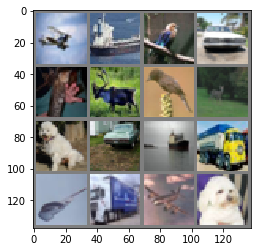

In [44]:
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline # Notebook形式の場合画像を表示させるのに必要

def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 訓練データをランダムに取得
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 画像の表示
imshow(torchvision.utils.make_grid(images, nrow=4))
# ラベルの表示
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [57]:
torch.tensor(1).item()

1